In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [20, 25, 30, 35]
runlist = [[1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
            [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
            [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
            [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465]
#            [1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478]
          ]
          
bias = np.array([[53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0]
#                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 'Vbd', 'spe_3V_over', 'spe_55V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept
            spe_55V_fix = slope*55+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_55V_fix': spe_55V_fix}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

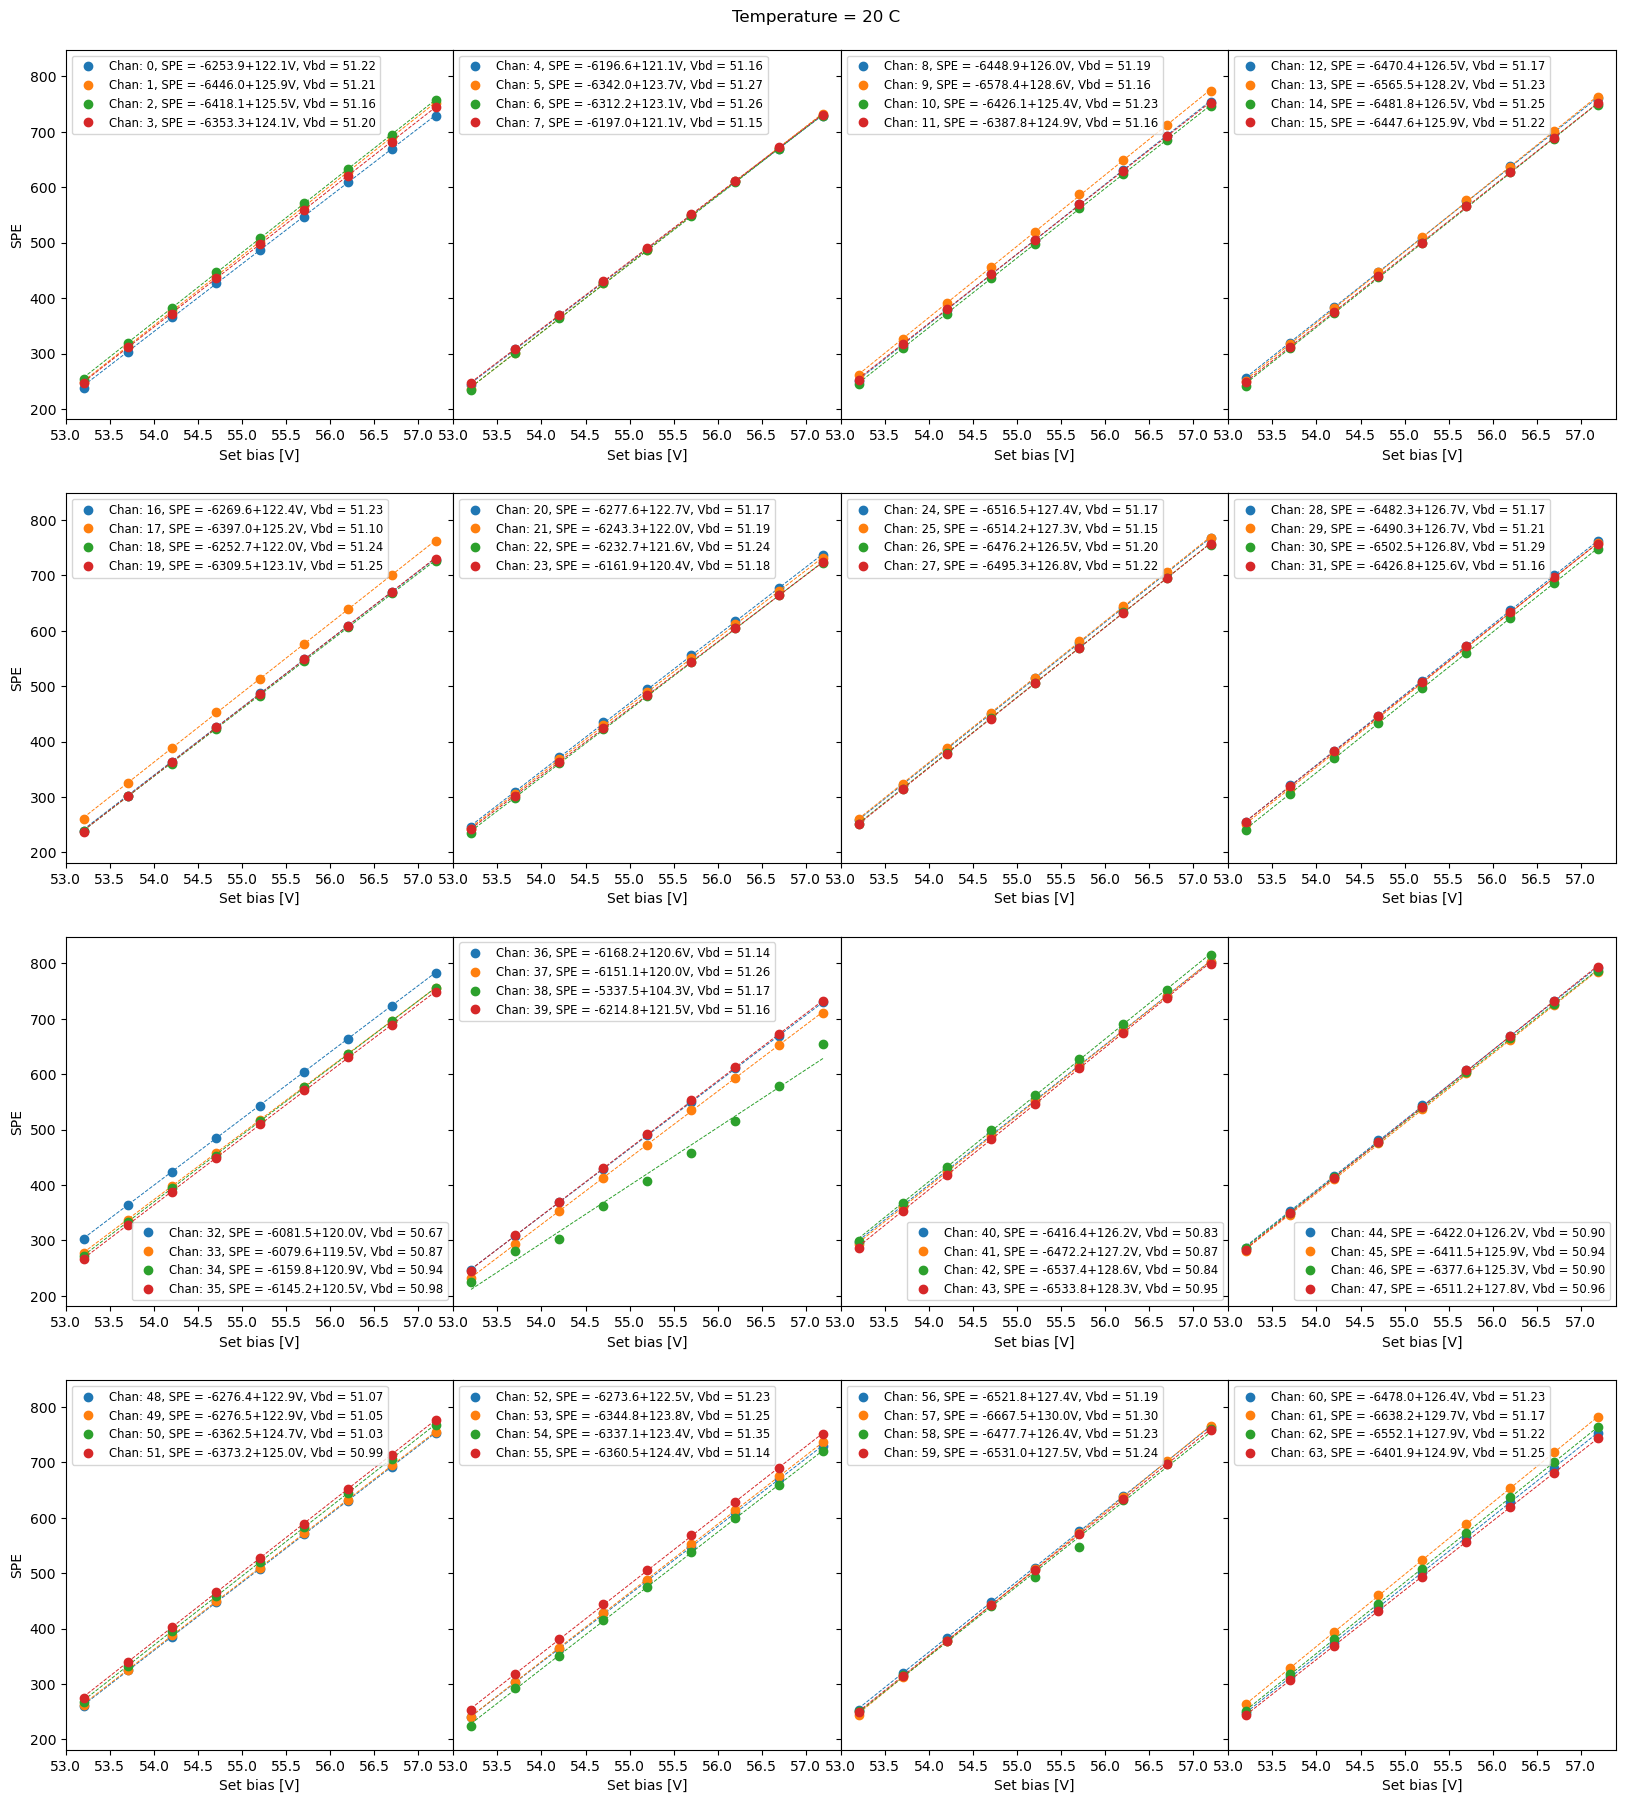

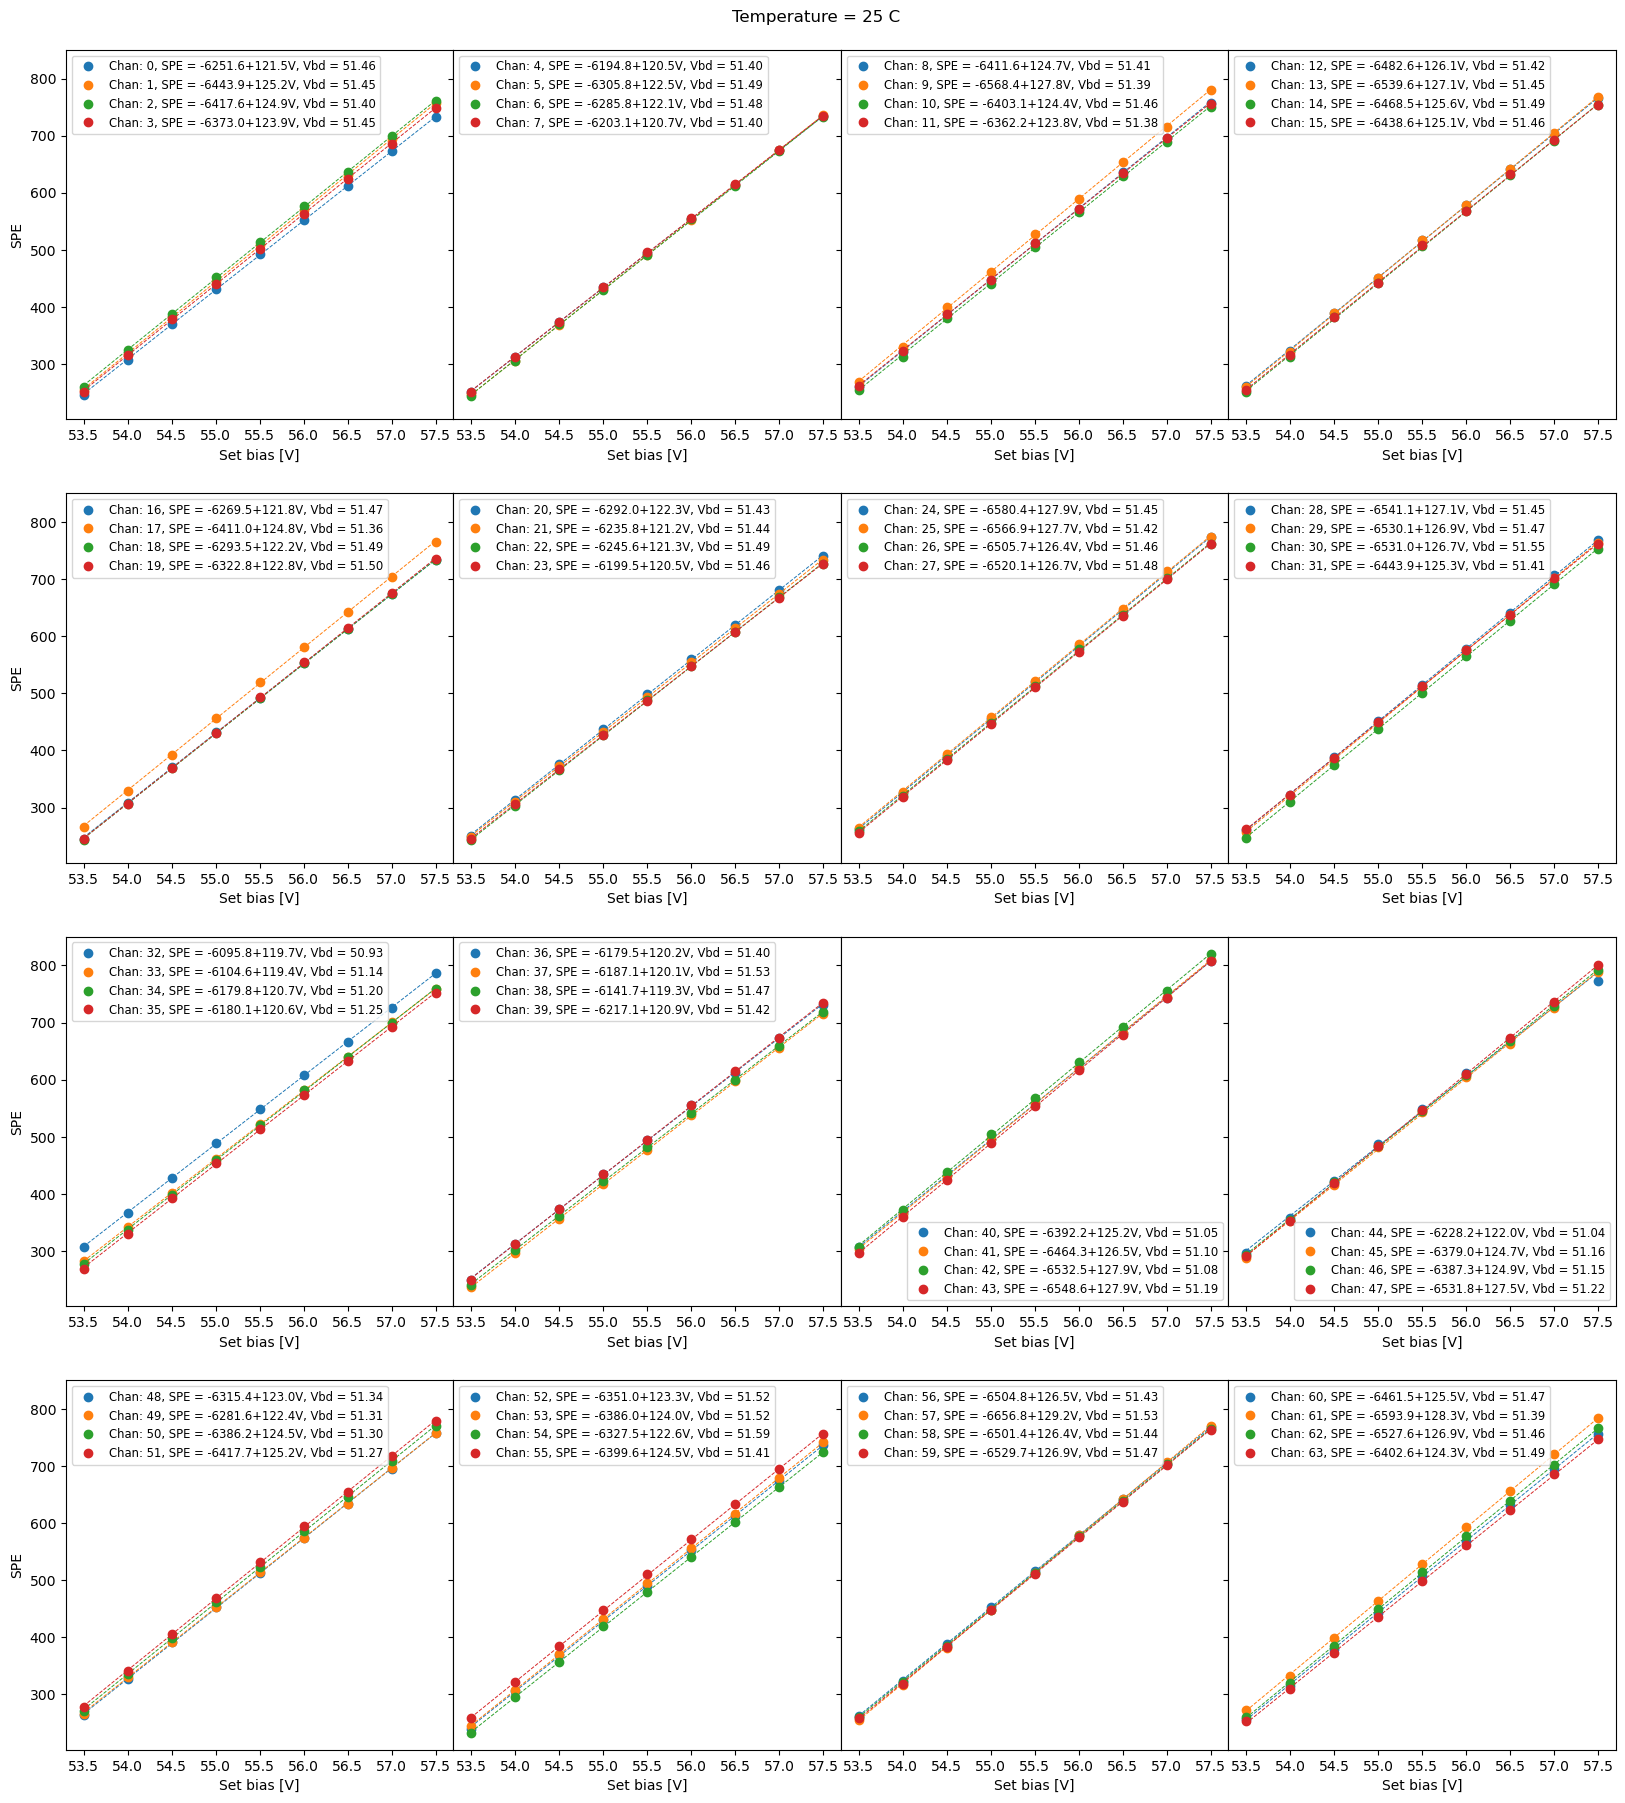

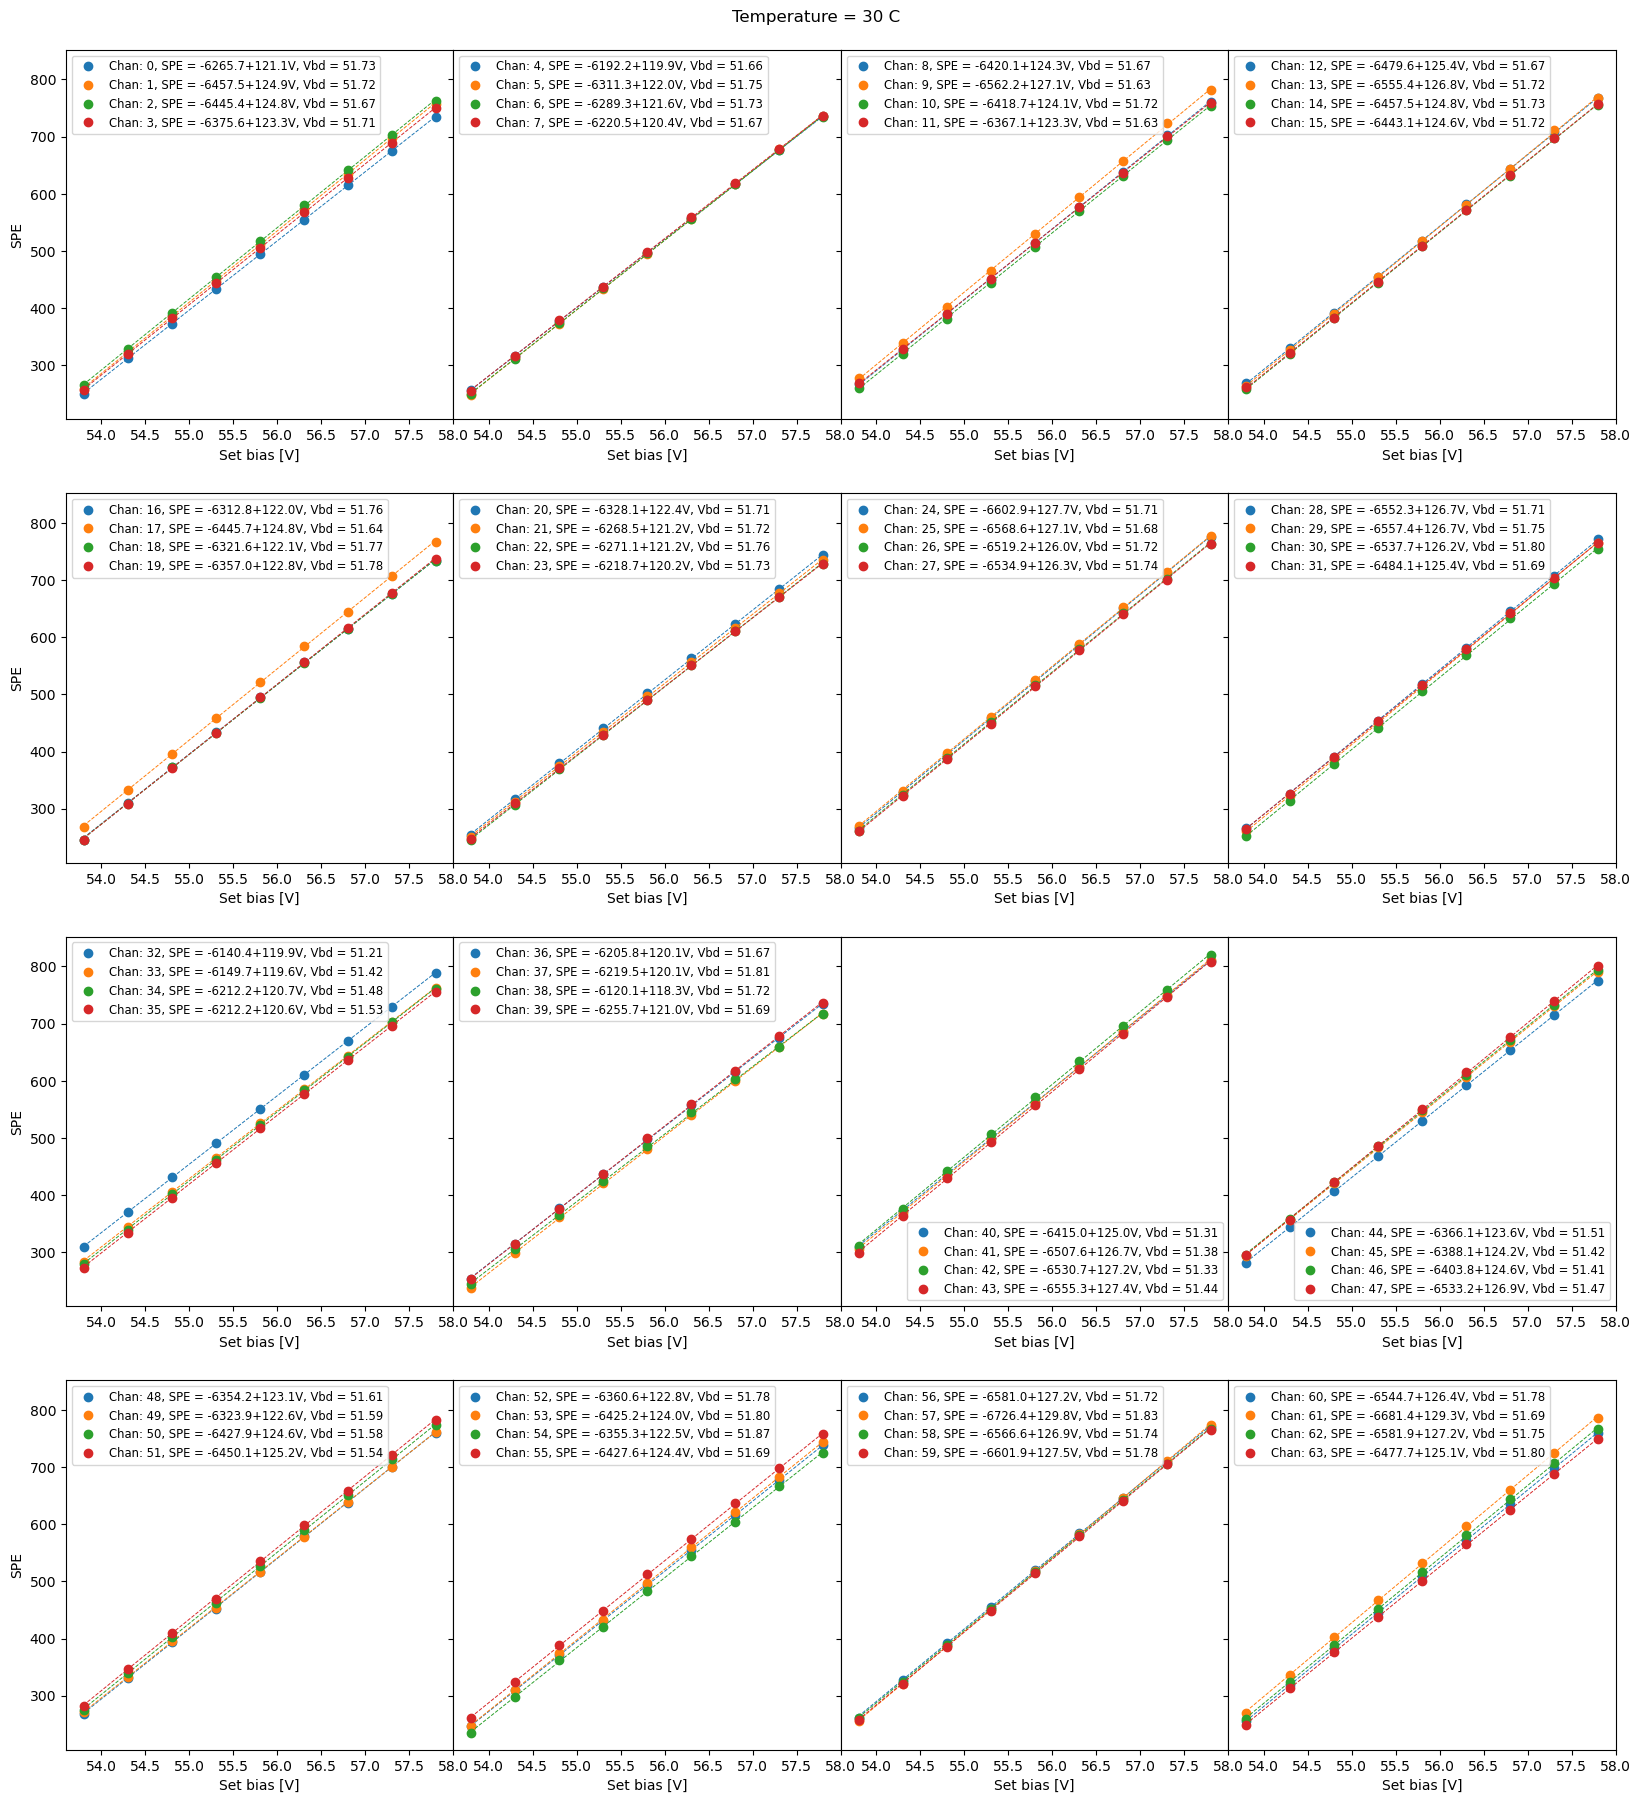

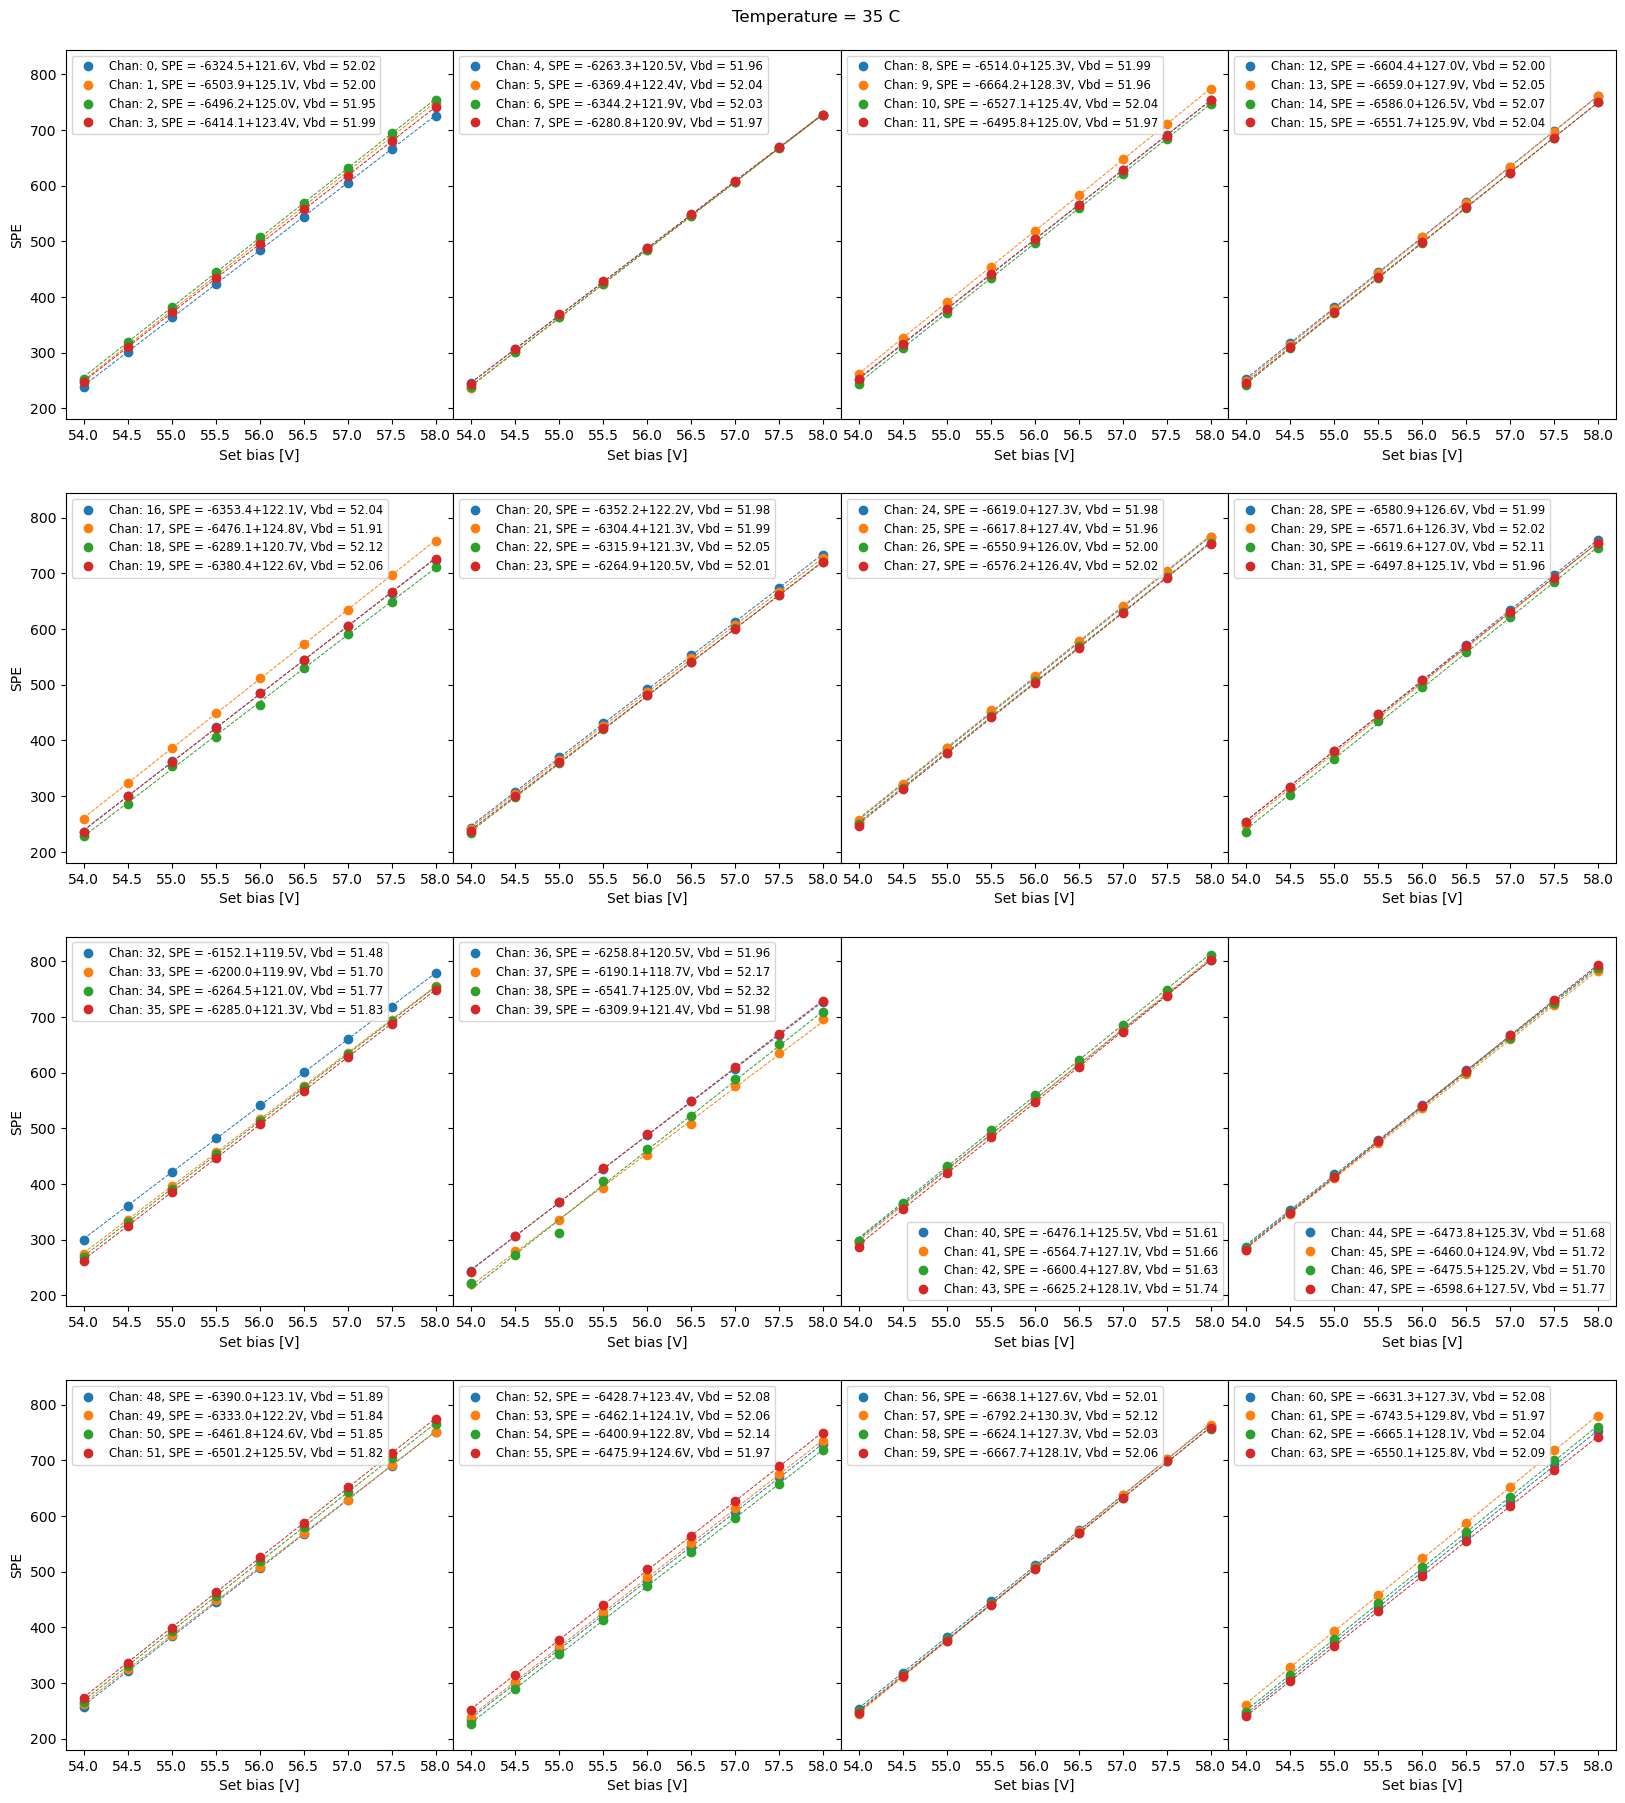

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'calibConstants'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

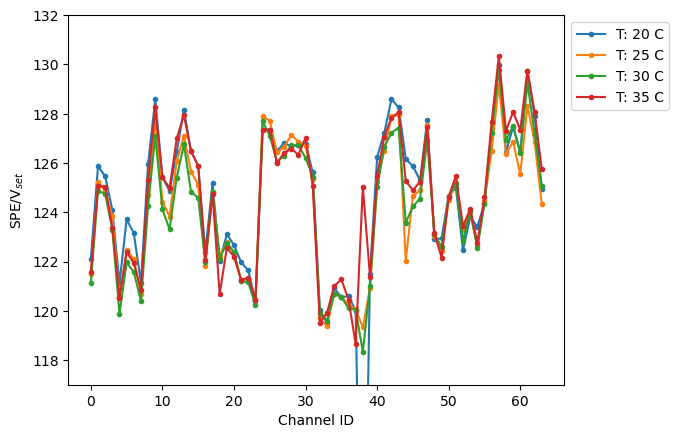

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %d'%temp)['chan'], df.query('temp == %d'%temp)['slope'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("SPE/V$_{set}$");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(117, 132);

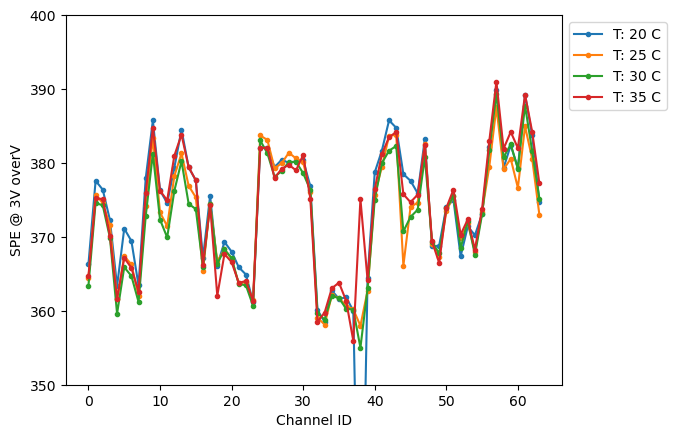

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %d'%temp)['chan'], df.query('temp == %d'%temp)['spe_3V_over'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("SPE @ 3V overV");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylim(350, 400);

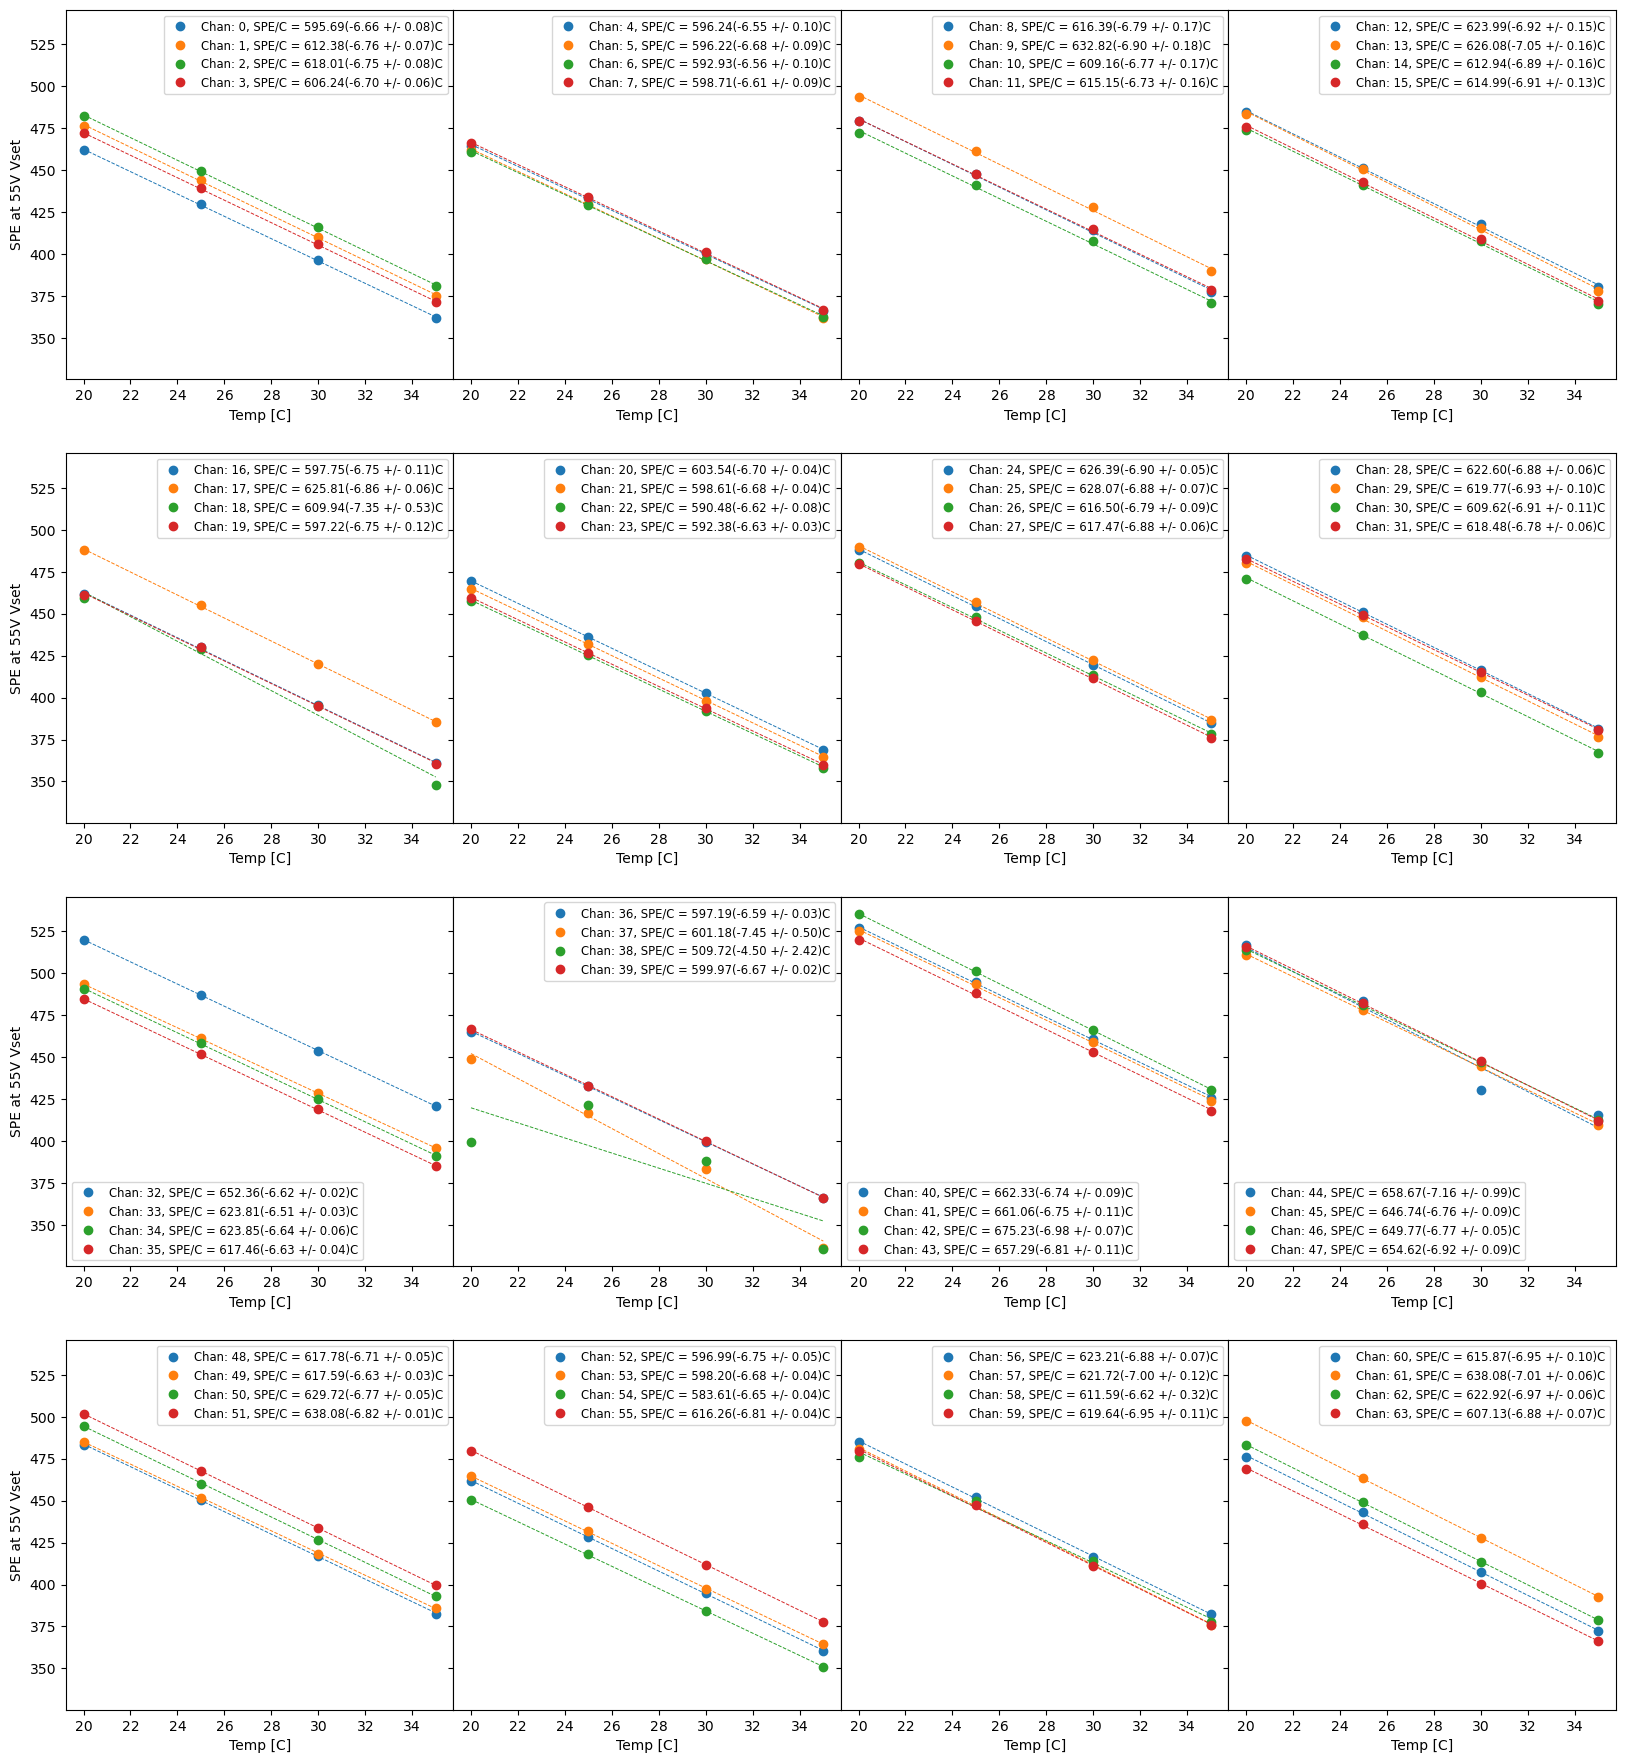

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE at 55V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_55V_fix']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

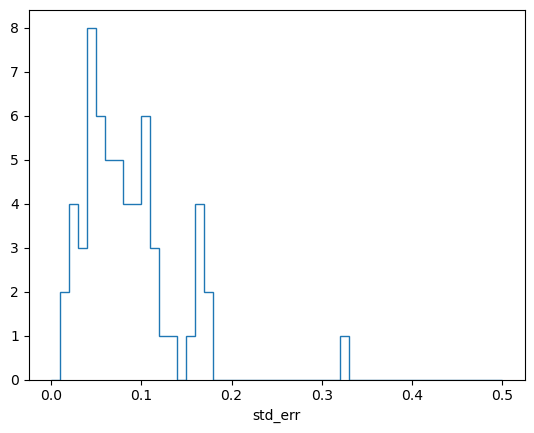

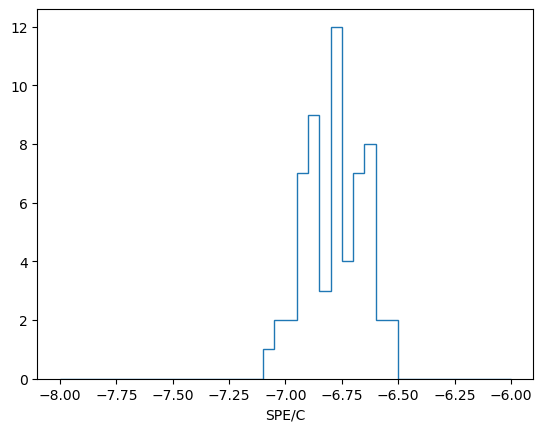

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50, range=(0,0.5));
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.2')['slope'], histtype='step', range=(-8,-6), bins=40);
plt.xlabel('SPE/C');
plt.figtext(0.65,0.65, dfSPE_Temp['slope'].describe().loc[['mean','std']].to_string())

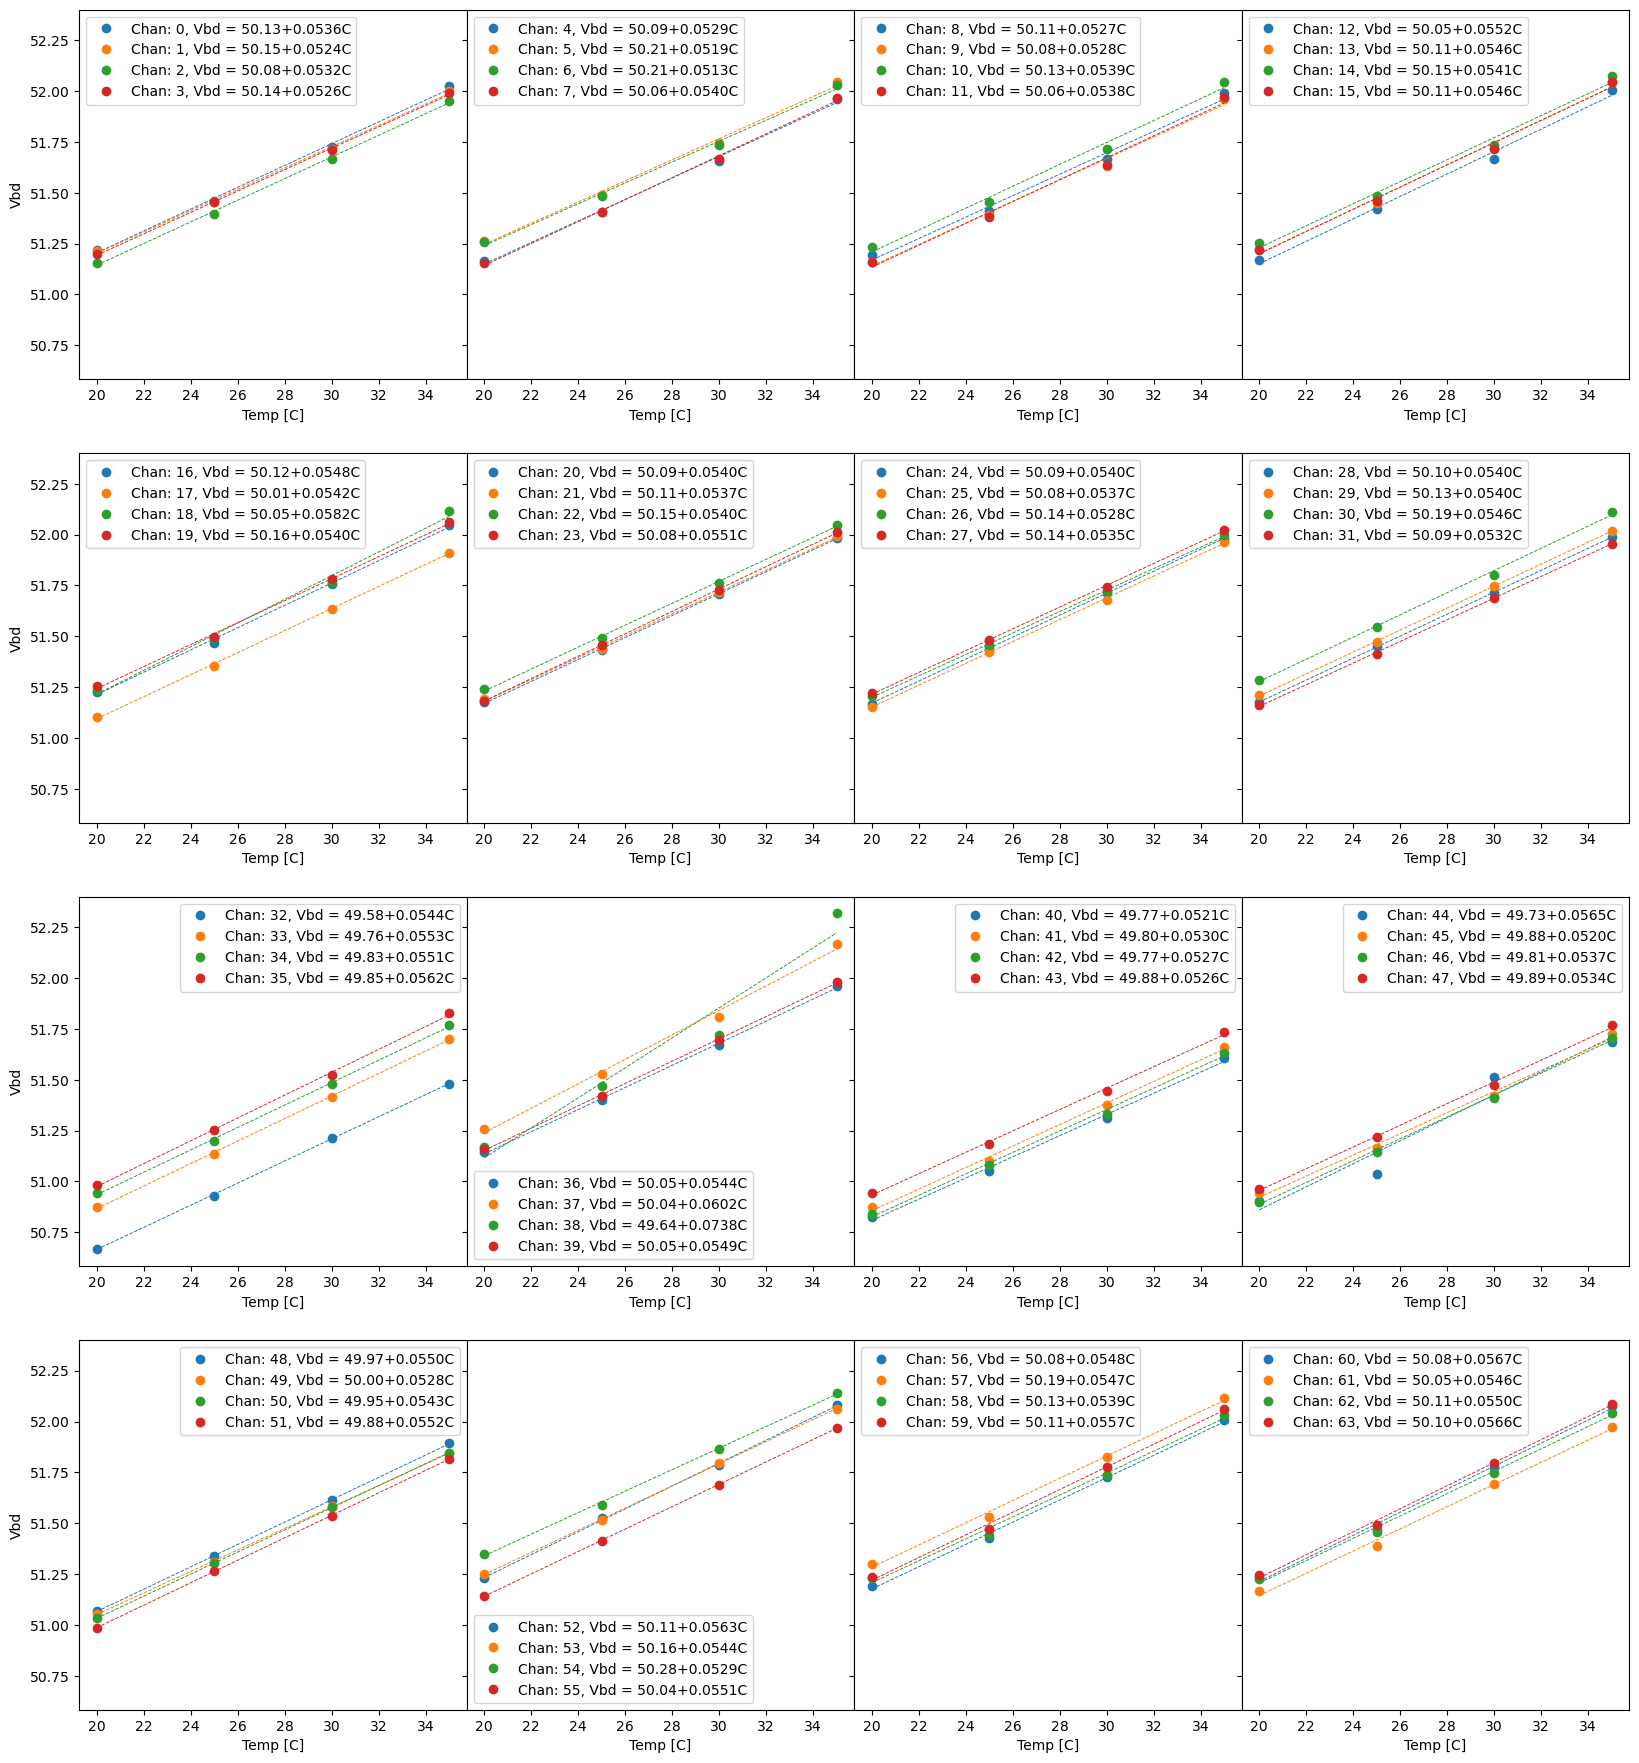

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfVbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['Vbd']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
           'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        dfVbd.loc[len(dfVbd)] = new_row
        ax.legend()

Text(0.65, 0.65, 'mean    54.522727\nstd      2.861437')

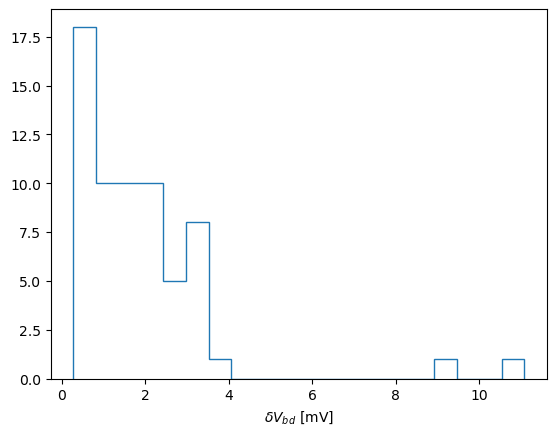

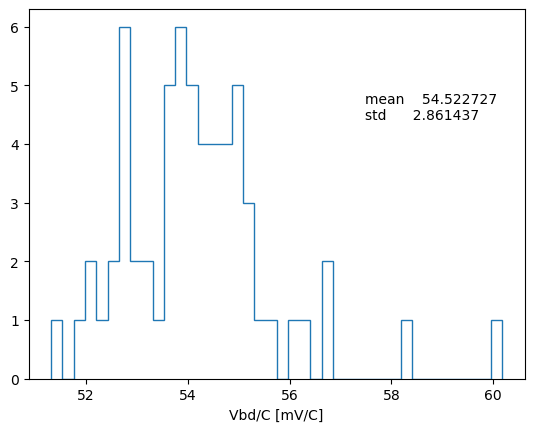

In [9]:
plt.hist(dfVbd['std_err'], histtype='step', bins=20)
plt.xlabel("$\delta V_{bd}$ [mV]")
plt.figure()

var = dfVbd.query('std_err<5')['slope']
plt.hist(var, histtype='step', bins=40);
plt.xlabel("Vbd/C [mV/C]")
plt.figtext(0.65,0.65, dfVbd['slope'].describe().loc[['mean','std']].to_string())

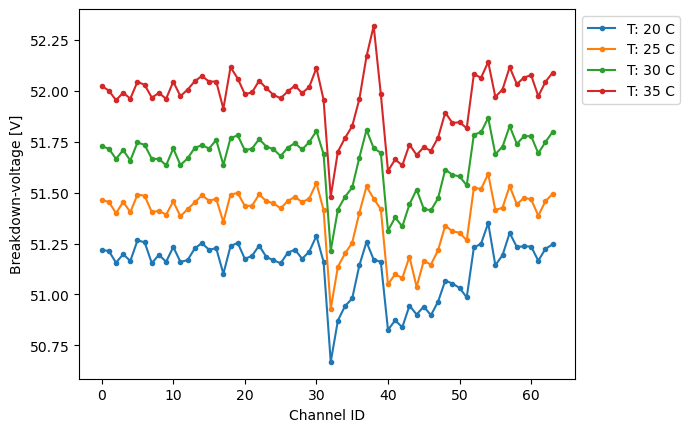

In [10]:
for temp in templist:
    plt.plot(df.query('temp == %d'%temp)['chan'], df.query('temp == %d'%temp)['Vbd'], '.-', label=('T: %d C'%temp))
    plt.xlabel("Channel ID")
    plt.ylabel("Breakdown-voltage [V]");
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

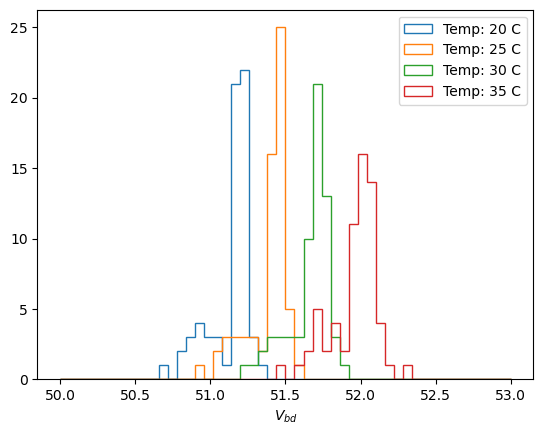

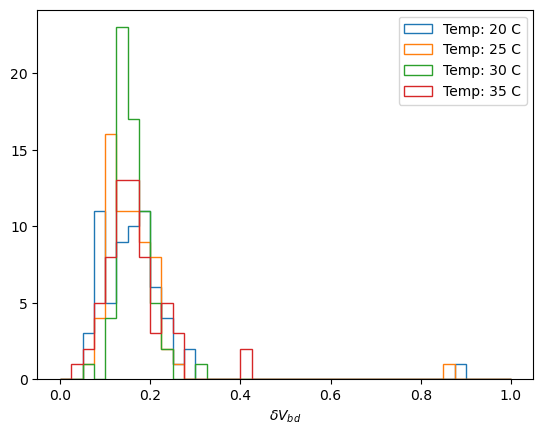

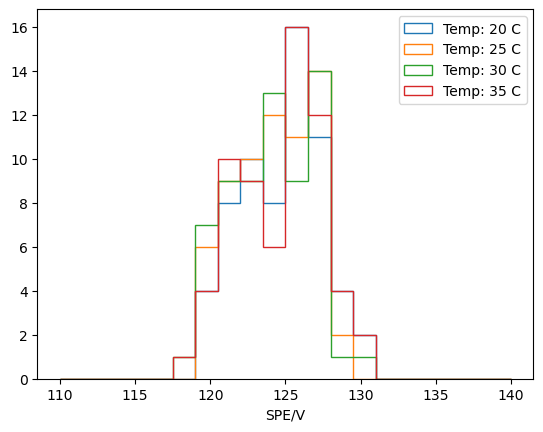

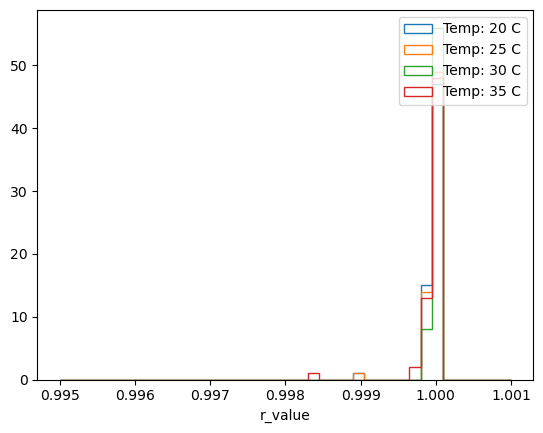

In [11]:

for temp in templist:
    plt.hist(df.query('temp == %d'%temp)['Vbd'], bins=50, range=(50, 53), histtype='step', label='Temp: %d C'%temp);
    plt.legend()
    plt.xlabel('$V_{bd}$');
    
plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %d'%temp)['std_err'], bins=40, range=(0, 1), histtype='step', label='Temp: %d C'%temp);
    plt.xlabel('std_err');
    plt.legend()
    plt.xlabel('$\delta V_{bd}$')

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %d'%temp)['slope'], bins=20, range=(110, 140), histtype='step', label='Temp: %d C'%temp);
    plt.legend()
    plt.xlabel('SPE/V');

plt.figure()
for temp in templist:
    plt.hist(df.query('temp == %d'%temp)['r_value'], bins=40, range=(0.995, 1.001), histtype='step', label='Temp: %d C'%temp);
    plt.legend()
    plt.xlabel('r_value');

In [12]:
pd.set_option('display.max_rows', None)
df

,chan,slope,temp,intercept,r_value,p_value,std_err,Vbd,spe_3V_over,spe_55V_fix
0,0,122.103262,20,-6253.876783,0.999940,5.427506e-15,0.211623,51.217934,366.309787,461.802645
1,1,125.865493,20,-6446.006859,0.999978,1.646190e-16,0.128421,51.213456,377.596478,476.595243
2,2,125.462036,20,-6418.095978,0.999956,1.820940e-15,0.180830,51.155682,376.386108,482.316010
3,3,124.093930,20,-6353.282668,0.999968,6.413660e-16,0.155912,51.197369,372.281790,471.883484
4,4,121.111937,20,-6196.603923,0.999941,5.065430e-15,0.209326,51.164270,363.335812,464.552637
5,5,123.709067,20,-6341.958046,0.999943,4.639645e-15,0.207124,51.265103,371.127200,462.040627
6,6,123.149428,20,-6312.173088,0.999913,2.054791e-14,0.256149,51.256211,369.448285,461.045468
7,7,121.145868,20,-6197.027147,0.999976,2.273551e-16,0.134326,51.153434,363.437604,465.995588
8,8,125.968103,20,-6448.894976,0.999950,2.867277e-15,0.193095,51.194666,377.904309,479.350691
9,9,128.584200,20,-6578.400942,0.999945,4.160870e-15,0.203509,51.160259,385.752600,493.730059
